# Study the systematics of WISE and Spitzer IRS data
#### I will compare:
* W3, W4 with Spitzer IRS
* Spitzer MIPS 70 $\mu m$ with Herschel PACS 70 $\mu m$

and use the results in our systematic test.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import Fitter.sedfit.SED_Toolkit as sedt
from Fitter.sedfit.fitter import basicclass as bc
from Fitter.sedfit import sedclass as sedsc
from astropy.table import Table, Column

plt.style.use('classic')
plt.rc('font',family='Times New Roman')
%matplotlib inline

## $\bullet$ Load the WISE and Spitzer IRS data

In [2]:
sedPath = "/Volumes/Transcend/Work/PG_QSO/catalog/Data_SG/SEDs/"
PG_QSO_path = "/Volumes/Transcend/Work/PG_QSO/catalog/data/"
wiseTb = Table.read("/Volumes/Transcend/Work/PG_QSO/catalog/Data_SG/pg_nir_final.ipac", format="ascii.ipac")
infoTable = Table.read(PG_QSO_path+"PG_info.ipac", format="ascii.ipac")
#wiseCC = Table.read("tabs/bak/wise_color_correction.ipac", format="ascii.ipac")
nameList = infoTable["Name"]
zList = infoTable["z"]
colNames = ('wavelength', 'flux', 'sigma')

### 1. Collect the WISE and IRS calculated W3 and W4 bands
* The large deviation in W3 is addressed http://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html#blue_red. We correct the W3 by increase it by 17% for each of the objects.
* According to http://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html, all the targets with $\alpha > 1$ are reduced in W4 flux with 0.9.
* The deviation of W3 and W4 are small (~0 dex).
* Since there is not correction method on W3 provided, we choose to increase the W3 flux density of the entire sample by 16%.
* The systematic deviations and their scatters are consistent with ALLWISE data comparing with IRS spectra.

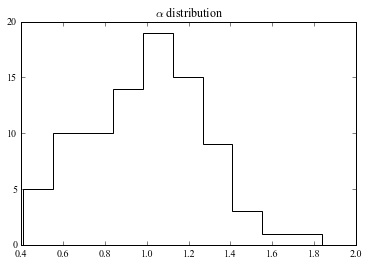

In [3]:
alphaList = []
wise_w3 = []
wise_w4 = []
e_wise_w3 = []
e_wise_w4 = []
irs_w3  = []
irs_w4  = []
for loop in range(len(nameList)):
    targname = nameList[loop]
    z = zList[loop]
    sedFile = sedPath+"{0}_obs.csed".format(targname)
    sedPck = sedt.Load_SED(sedFile)
    sed = sedPck["pht"]
    spc = sedPck["spc"]
    bandList = ["WISE_w1", "WISE_w2", "WISE_w3", "WISE_w4"]
    sedName  = "Phot"
    spcName  = "IRS"
    sed = sedt.SED_to_restframe(sed, z)
    sed = sedt.SED_select_band(sed, bandList)
    spc = sedt.SED_to_restframe(spc, z)
    sedwave  = sed[0]
    sedflux  = sed[1]
    sedsigma = sed[2]
    sedband  = sed[3]
    spcwave  = np.array(spc[0])
    spcflux  = np.array(spc[1])
    spcsigma = np.array(spc[2])
    
    sedflag = np.ones_like(sedwave)
    sedDataType = ["name", "wavelength", "flux", "error", "flag"]
    phtData = {sedName: bc.DiscreteSet(sedband, sedwave, sedflux, sedsigma, sedflag, sedDataType)}
    spcflag = np.ones_like(spcwave)
    spcDataType = ["wavelength", "flux", "error", "flag"]
    spcData = {"IRS": bc.ContinueSet(spcwave, spcflux, spcsigma, spcflag, spcDataType)}
    sedData = sedsc.SedClass(targname, z, phtDict=phtData, spcDict=spcData)
    sedData.set_bandpass(sedband, sedwave)
    
    ws_w1 = wiseTb["w1_flux"][loop]*(1+z) #sedflux[0]
    ws_w3 = wiseTb["w3_flux"][loop]*(1+z) #sedflux[2]
    ws_w4 = wiseTb["w4_flux"][loop]*(1+z) #sedflux[3]
    ws_ew3 = wiseTb["w3_rms"][loop]*(1+z)
    ws_ew4 = wiseTb["w4_rms"][loop]*(1+z)
    alpha = (np.log10(ws_w4) - np.log10(ws_w1)) / (np.log10(sedwave[3]) - np.log10(sedwave[0]))
    if alpha > 0.7:
        c4 = 0.9 #Further correction
    else:
        c4 = 1.
    ws_w4 = ws_w4 * c4
    ws_ew4 = ws_ew4 * c4
    alphaList.append(alpha)
    #Calculate the W3 and W4 from IRS spectra
    sp_w3 = sedData.filtering("WISE_w3", spcwave, spcflux)[1]
    sp_w4 = sedData.filtering("WISE_w4", spcwave, spcflux)[1]
    #Collect the data
    wise_w3.append(ws_w3)
    wise_w4.append(ws_w4)
    e_wise_w3.append(ws_ew3)
    e_wise_w4.append(ws_ew4)
    irs_w3.append(sp_w3)
    irs_w4.append(sp_w4)
    
    #fig, ax = sedData.plot_sed()
    #ax.set_title("{0}, a={1:.2f}".format(targname, alpha))
    #plt.show()
    
alphaList = np.array(alphaList)
corr_w3 = 0.17
wise_w3 = (1 + corr_w3) * np.array(wise_w3)
wise_w4 = np.array(wise_w4)
e_wise_w3 = (1 + corr_w3) * np.array(e_wise_w3)
e_wise_w4 = np.array(e_wise_w4)
irs_w3  = np.array(irs_w3)
irs_w4  = np.array(irs_w4)

plt.hist(alphaList, bins=10, histtype="step", color="k")
plt.title(r"$\alpha$ distribution")
plt.show()

* W3 relative deviation

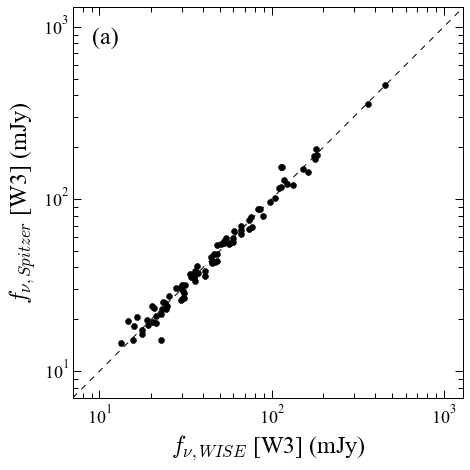

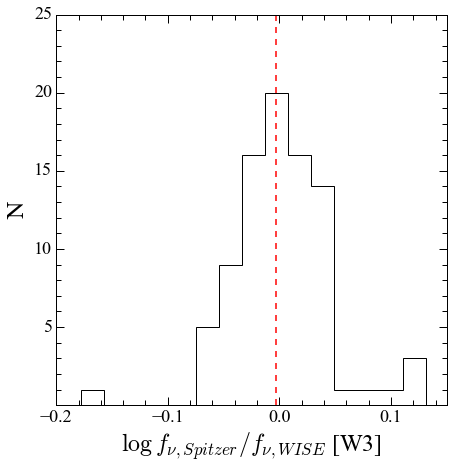

The median of the relative systematic deviation of WISE from Spitzer IRS is -0.00 dex.
The dispersion of the relative systematic deviation of WISE from Spitzer IRS is 0.04 dex.


In [4]:
x = wise_w3
y = irs_w3

fig = plt.figure(figsize=(7, 7))
ax = plt.gca()
#plt.plot(x, y, linestyle="none", marker="o", color="k")
plt.errorbar(x, y, xerr=e_wise_w3, linestyle="none", marker="o", color="k")
plt.xscale("log")
plt.yscale("log")
amin, amax = [7, 1.3e3]
plt.plot([amin, amax], [amin, amax], linestyle="--", color="k")
plt.xlabel(r"$f_{\nu, WISE}$ [W3] (mJy)", fontsize=24)
plt.ylabel(r"$f_{\nu, Spitzer}$ [W3] (mJy)", fontsize=24)
ax.set_xlim([amin, amax])
ax.set_ylim([amin, amax])
ax.minorticks_on()
ax.tick_params(axis='both', which='major', length=8, labelsize=18, width=1.)
ax.tick_params(axis='x', pad=6)
ax.tick_params(axis="both", which="minor", length=5, width=1.)
ax.text(0.05, 0.95, "(a)", fontsize=24, transform=ax.transAxes, 
        horizontalalignment='left', verticalalignment='top')
plt.xticks([1e1, 1e2, 1e3])
plt.yticks([1e1, 1e2, 1e3])
plt.savefig("figs/sys_w3_corr.pdf", bbox_inches="tight")
plt.show()

dev = np.log10(y) - np.log10(x)
med_dev = np.median(dev)
sig_dev = np.std(dev)
fig = plt.figure(figsize=(7, 7))
ax = plt.gca()
plt.hist(dev, 15, histtype="step", color="k")
plt.axvline(x=med_dev, color="r", lw=1.5, linestyle="--")
plt.xlabel(r"$\mathrm{log}\,f_{\nu, Spitzer}/f_{\nu, WISE}$ [W3]", fontsize=24)
plt.ylabel("N", fontsize=24)
ax.minorticks_on()
ax.tick_params(axis='both', which='major', length=8, labelsize=18, width=1.)
ax.tick_params(axis="both", which="minor", length=5, width=1.)
plt.xticks(np.arange(-0.2, 0.2, 0.1))
plt.yticks(np.arange(5, 30, 5))
#plt.savefig("figs/sys_w3_hist.pdf", bbox_inches="tight")
plt.show()

print("The median of the relative systematic deviation of WISE from Spitzer IRS is {0:.2f} dex.".format(med_dev))
print("The dispersion of the relative systematic deviation of WISE from Spitzer IRS is {0:.2f} dex.".format(sig_dev))

* W4 relative deviation

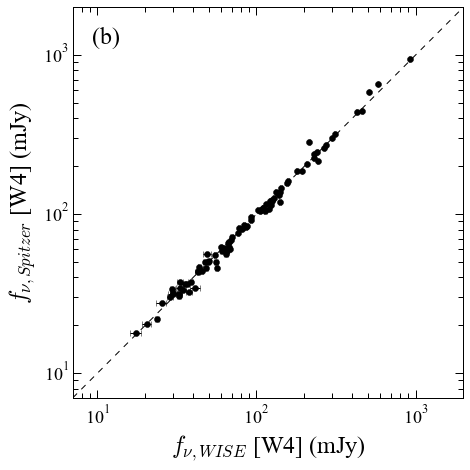

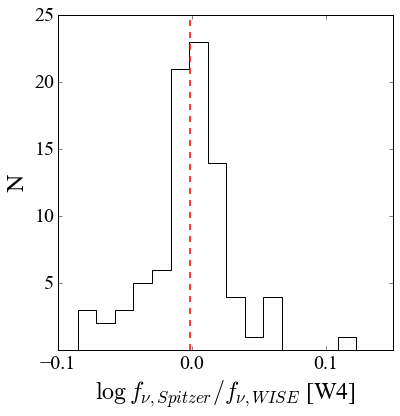

The median of the relative systematic deviation of WISE from Spitzer IRS is -0.00 dex.
The dispersion of the relative systematic deviation of WISE from Spitzer IRS is 0.03 dex.


In [5]:
x = wise_w4
y = irs_w4

fig = plt.figure(figsize=(7, 7))
ax = plt.gca()
#plt.plot(x, y, linestyle="none", marker="o", color="k")
plt.errorbar(x, y, xerr=e_wise_w4, linestyle="none", marker="o", color="k")
plt.xscale("log")
plt.yscale("log")
amin, amax = [7, 2e3]
plt.plot([amin, amax], [amin, amax], linestyle="--", color="k")
plt.xlabel(r"$f_{\nu, WISE}$ [W4] (mJy)", fontsize=24)
plt.ylabel(r"$f_{\nu, Spitzer}$ [W4] (mJy)", fontsize=24)
ax.set_xlim([amin, amax])
ax.set_ylim([amin, amax])
ax.minorticks_on()
ax.tick_params(axis='both', which='major', length=8, labelsize=18, width=1.)
ax.tick_params(axis='x', pad=6)
ax.tick_params(axis="both", which="minor", length=5, width=1.)
ax.text(0.05, 0.95, "(b)", fontsize=24, transform=ax.transAxes, 
        horizontalalignment='left', verticalalignment='top')
plt.xticks([1e1, 1e2, 1e3])
plt.yticks([1e1, 1e2, 1e3])
plt.savefig("figs/sys_w4_corr.pdf", bbox_inches="tight")
plt.show()

dev = np.log10(y) - np.log10(x)
fltr = np.logical_not(np.isnan(dev))
med_dev = np.median(dev[fltr])
sig_dev = np.std(dev[fltr])
fig = plt.figure(figsize=(6, 6))
ax = plt.gca()
plt.hist(dev[fltr], 15, histtype="step", color="k")
plt.axvline(x=med_dev, color="r", lw=1.5, linestyle="--")
plt.xlabel(r"$\mathrm{log}\,f_{\nu, Spitzer}/f_{\nu, WISE}$ [W4]", fontsize=24)
plt.ylabel("N", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.xticks(np.arange(-0.1, 0.15, 0.1))
plt.yticks(np.arange(5, 30, 5))
#plt.savefig("figs/sys_w4_hist.pdf", bbox_inches="tight")
plt.show()

print("The median of the relative systematic deviation of WISE from Spitzer IRS is {0:.2f} dex.".format(med_dev))
print("The dispersion of the relative systematic deviation of WISE from Spitzer IRS is {0:.2f} dex.".format(sig_dev))